In [32]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# PROGETTO iNEST: OTTIMIZZAZIONE DELLA LOGISTICA PORTUALE

In questo report viene pesentata l'analisi descrittiva dei dati relativi alle registrazioni nel sistema Sinfomar delle singole unità in imbarco presso il porto nel periodo di Febbraio 2023.
La stessa analisi viene poi riproposta anche per i dati ViGate di attraversamento dei gate portuali in entrata nel periodo da Maggio 2022 ad Aprile 2023. 

Questi dati vengono poi accorpati e messi a confronto per il periodo di Febbraio 2023, con una breve analisi dell'intervallo di tempo che intercorre tra la registrazione di un veicolo nel sistema Sinfomar e il suo effettivo passaggio al Gate.

In [33]:
#IMPORT LIBRERIE

import pandas as pd
import matplotlib.pyplot as plt
from timeseria import logger

from IPython.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 15px; }</style>"))

import logging
logging.basicConfig(level='INFO')


from timeseria.datastructures import DataTimePointSeries

import warnings
warnings.filterwarnings("ignore")

## ESTRAZIONE E PREPROCESSING DEI DATI (SINFOMAR)

Si prendono in considerazione i dati di registrazione nel sistema Sinfomar, selezionando solo le registrazioni di tipo Import. Vengono effettuate alcune operazioni di pulizia dei dati, in particolare viene formattata la data.

In [34]:
#ESTRAZIONE DATI REGISTRAZIONI

regdata = pd.read_csv('GPR_registrazioni.csv', sep=";",error_bad_lines=False)

In [35]:
#SELEZIONE ESCLUSIVAMENTE REGISTRAZIONE TIPO IMPORT

regdata_imb = regdata.loc[regdata["tipobk"]==1]

In [36]:
#FORMATTAZIONE DATASET

regdata_pp = regdata_imb[['id', 'useridins', 'userins', 'dittaid', 'datains', 'datamod', 'targhe','terminal','targamot', 'targarim','porto_imbarco', 'porto_destfin', 'partenza', 'destinazione']]

regdata_pp.rename(columns={"id":"code"},inplace=True)

In [37]:
#FORMATTAZIONE DATA

regdata_pp['insdate'] = pd.to_datetime(regdata_pp['datains'], format='%Y/%m/%d %H:%M:%S')

VISUALIZZAZIONE DINAMICA DATI SINFOMAR FEBBRAIO 2023

Attraverso la libreria "Timeseria" (https://github.com/sarusso/Timeseria) possiamo procedere con una visualizzazione dinamica del dato relativo alla quantità di registrazioni orarie nel corso del periodo in considerazione: la finestra temporale può essere cambiata dall'utente, inoltre spostandosi con il cursore sui singoli punti viene visualizzato il dato relativo all'istante scelto.

In [38]:
#VISUALIZZAZIONE DINAMICA DATI SINFOMAR FEBBRAIO 2023

regdata_pp['time_since_last'] = regdata_pp['insdate'].diff().dt.total_seconds()


df_filtered_r = regdata_pp.loc[regdata_pp['time_since_last']>20]


df_filtered_r['Quantity'] = 1


df_r = df_filtered_r.resample('H', origin='start',on='insdate').Quantity.sum()
df_r

df_r = df_r.to_frame()
logger.setup(level='INFO')
ts_r = DataTimePointSeries(df_r)
ts_r.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ESTRAZIONE E PREPROCESSING DEI DATI (VIGATE)

Similmente a quanto fatto per i dati Sinfomar, si procede con importazione e formattazione dei dati ViGate

In [39]:
#IMPORT DATI VIGATE

datiporto = pd.read_excel('EXPORT_G1L1.xlsx')

In [40]:
#FORMATTAZIONE DATA

datiporto['startdate'] = pd.to_datetime(datiporto['DATA INIZIO TRANSITO'], format='%d/%m/%Y : %H:%M:%S')

VISUALIZZAZIONE DINAMICA DATI VIGATE COMPLETI

Anche in questo caso procediamo con la visualizzazione dinamica del dato relativo alla quantità di transiti orari al gate.

In [41]:
#VISUALIZZAZIONE DINAMICA DATI VIGATE COMPLETI


datiporto['time_since_last'] = datiporto['startdate'].diff().dt.total_seconds()


df_filtered_p = datiporto.loc[datiporto['time_since_last']>20]


df_filtered_p['Quantity'] = 1


df_p = df_filtered_p.resample('H', origin='start',on='startdate').Quantity.sum()
df_p

df_p = df_p.to_frame()
logger.setup(level='INFO')
ts_p = DataTimePointSeries(df_p)
ts_p.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CREAZIONE DATASET VIGATE SOLO FEBBRAIO 2023

Per semplicità e per confrontare meglio le differenze tra registrazioni e passaggi al gate, viene presa ora in considerazione la porzione del dataset ViGate che fa riferimento esclusivamente a il periodo di Febbraio 2023.

In [42]:
import datetime as dt
start =datiporto.startdate.searchsorted(dt.datetime(2023,2,1))
end =datiporto.startdate.searchsorted(dt.datetime(2023,3,1))

portoFeb = datiporto.iloc[start:end]

In [43]:
portoFeb['DATA INIZIO TRANSITO'] = pd.to_datetime(portoFeb['DATA INIZIO TRANSITO'], format='%d/%m/%Y : %H:%M:%S')

VISUALIZZAZIONE DINAMICA DATI VIGATE FEBBRAIO

Come fatto sopra si procede con la visualizzazione dinamica.

In [44]:
#VISUALIZZAZIONE DINAMICA DATI PASSAGGIO GATE FEBBRAIO


portoFeb['time_since_last'] = portoFeb['DATA INIZIO TRANSITO'].diff().dt.total_seconds()


df_filtered_p_feb = portoFeb.loc[portoFeb['time_since_last']>20]


df_filtered_p_feb['Quantity'] = 1


df_p_feb = df_filtered_p_feb.resample('H', origin='start',on='DATA INIZIO TRANSITO').Quantity.sum()


df_p_feb = df_p_feb.to_frame()
logger.setup(level='INFO')
ts_p_feb = DataTimePointSeries(df_p_feb)
ts_p_feb.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Appare evidente una sostanziale mancanza di dati per la quasi totalità del mese. Ciò riduce pesantemente la possibilità di confronti con i dati delle registrazioni. Per ottenere un match dei dati utilizzabili, viene usata l'associazione tramite targa.

MATCH DATI A PARTIRE DALLA TARGA

Innanzitutto vengono estratti e ripuliti dai valori mancanti i dati di targa per entrambi i dataset.

In [45]:
#ESTRAZIONE DATI DI TARGA

port_targ = portoFeb['TARGA'].tolist()

sinf_targ = regdata_pp['targamot'].tolist()

port_targ1 = [targ for targ in port_targ if str(targ) != 'nan']

sinf_targ1 = [targ for targ in sinf_targ if str(targ) != 'nan']

Per far fronte alle possibili imprecisioni dovute al sistema di riconoscimento utilizzato ai varchi viene implementato un sistema di string matching che associa ad ogni targa del dataset Sinfomar il suo corrispondente più vicino nei dati ViGate.

In [46]:
#FUNZIONE NATIVA PER IL MATCH DI STRINGHE

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [47]:
#FUNZIONE CUSTOM PER L'ASSOCIAZIONE DELLE TARGHE LATO PORTO E LATO SINFOMAR

from copy import copy
import numba as nb
from tqdm import tqdm


def plate_matcher(port,sinf):
    coordlist2=[]
    for i in tqdm(range(len(port))):
        kmax=0
        coord=(0,0)
        for j in range(len(sinf)):
            k = similar(str(port[i]),str(sinf[j]))
            if k > kmax:
                kmax=k
                coord=(i,j)
        coordlist2.append(coord)
    return(coordlist2)

In [48]:
#ESTRAZIONE COORDINATE TARGHE SIMILI
coordlist2=plate_matcher(port_targ1,sinf_targ1)


100%|██████████| 2408/2408 [06:30<00:00,  6.16it/s]


CREAZIONE DATASET UNICI

Per la creazione di dataset unificati, vengono associate le registrazioni con i passaggi al gate successivi di targhe similari avvenuti in un lasso di tempo variabile (48 o 24 ore dopo).

In [49]:
#CREAZIONE LISTE DI DATI A PARTIRE DA TARGA 

reg_dex=[]
por_dex=[]
por_times=[]
reg_times=[]

for i in tqdm(range(len(coordlist2))):
    por_dex.append(portoFeb['DATA INIZIO TRANSITO'].loc[portoFeb.TARGA == port_targ1[coordlist2[i][0]]].index.tolist())
    reg_dex.append(regdata_pp.datains.loc[regdata_pp.targamot == sinf_targ1[coordlist2[i][1]]].index.tolist())
    por_times.append(pd.to_datetime(portoFeb['DATA INIZIO TRANSITO'].loc[portoFeb.TARGA == port_targ1[coordlist2[i][0]]]).tolist())
    reg_times.append(pd.to_datetime(regdata_pp.datains.loc[regdata_pp.targamot == sinf_targ1[coordlist2[i][1]]]).tolist())

100%|██████████| 2408/2408 [00:08<00:00, 268.96it/s]


In [50]:
#CREAZIONE COLONNE DATASET, IMPOSTATO LIMITE DI VICINANZA TEMPORALE A 2 GIORNI

idx_matches=[]
reg_matchdex=[]
por_matchdex=[]
por_matchtime=[]
reg_matchtime=[]
timedelt = []

for i in tqdm(range(len(coordlist2))):
    for j in range(len(por_times[i])):
        portel = por_times[i][j]
        for k in range(len(reg_times[i])):
            regel = reg_times[i][k]
            if regel < portel:
                if portel - regel < dt.timedelta(days=2) and portel - regel > dt.timedelta(days=0):
                    idx_matches.append([reg_dex[i][k], por_dex[i][j]])
                    reg_matchdex.append(reg_dex[i][k])
                    por_matchdex.append(por_dex[i][j])
                    reg_matchtime.append(reg_times[i][k])
                    por_matchtime.append(por_times[i][j])
                    timedelt.append(portel - regel)
                    


            

100%|██████████| 2408/2408 [00:00<00:00, 36139.81it/s]


In [51]:
#CREAZIONE COLONNE DATASET, IMPOSTATO LIMITE DI VICINANZA TEMPORALE A 1 GIORNO

idx_matches1=[]
reg_matchdex1=[]
por_matchdex1=[]
por_matchtime1=[]
reg_matchtime1=[]
timedelt1 = []
checklist=[10,20,30,700,5000,7000, 10000,10002]
for i in tqdm(range(len(coordlist2))):
    for j in range(len(por_times[i])):
        portel = por_times[i][j]
        for k in range(len(reg_times[i])):
            regel = reg_times[i][k]
            if regel < portel:
                if portel - regel < dt.timedelta(days=1) and portel - regel > dt.timedelta(days=0):
                    idx_matches1.append([reg_dex[i][k], por_dex[i][j]])
                    reg_matchdex1.append(reg_dex[i][k])
                    por_matchdex1.append(por_dex[i][j])
                    reg_matchtime1.append(reg_times[i][k])
                    por_matchtime1.append(por_times[i][j])
                    timedelt1.append(portel - regel)

100%|██████████| 2408/2408 [00:00<00:00, 41663.27it/s]


In [52]:
#CREAZIONE DATASET, 2 GIORNI MAX DALLA REGISTRAZIONE

rel_df = pd.DataFrame(reg_matchdex, columns=['reg_index'])
rel_df['por_index']= por_matchdex
rel_df['reg_time'] = reg_matchtime
rel_df['por_time'] = por_matchtime
rel_df['time_interval'] = timedelt

Text(0.5, 1.0, 'Time from registration to gate passage (2d max)')

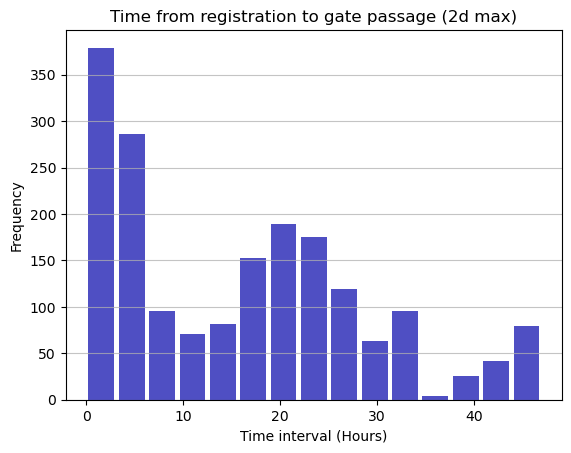

In [53]:
#DISTRIBUZIONE DEL TEMPO INTERCORSO TRA REGISTRAZIONE E PASSAGGIO AL VARCO DELLO STESSO VEICOLO (2 GIORNI MAX)

n, bins, patches = plt.hist(x=rel_df['time_interval'].astype('timedelta64[h]'), bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Time interval (Hours)')
plt.ylabel('Frequency')
plt.title('Time from registration to gate passage (2d max)')

Text(0.5, 1.0, 'Time from registration to gate passage (1d max)')

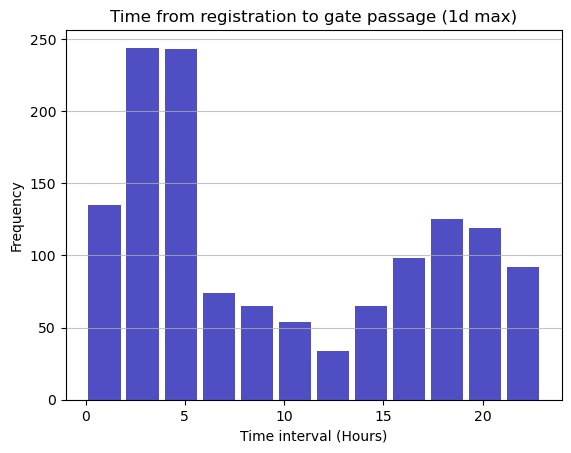

In [54]:
#CREAZIONE DATASET, 1 GIORNO MAX DALLA REGISTRAZIONE

rel_df1 = pd.DataFrame(reg_matchdex1, columns=['reg_index'])
rel_df1['por_index']= por_matchdex1
rel_df1['reg_time'] = reg_matchtime1
rel_df1['por_time'] = por_matchtime1
rel_df1['time_interval'] = timedelt1


#DISTRIBUZIONE DEL TEMPO INTERCORSO TRA REGISTRAZIONE E PASSAGGIO AL VARCO DELLO STESSO VEICOLO (2 GIORNI MAX)

n, bins, patches = plt.hist(x=rel_df1['time_interval'].astype('timedelta64[h]'), bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Time interval (Hours)')
plt.ylabel('Frequency')
plt.title('Time from registration to gate passage (1d max)')

Entrambe le distribuzioni sono multimodali: un picco nella frequenza si ha per intervalli di tempo compresi tra le 3 e 5 ore e un secondo picco di frequenza si ha attorno alle 21 ore di distanza.